# Creating, modifying, converting, and plotting graphs

## Creating and sampling graphs

Graphs are created by randomly sampling undirected binomial graphs. </br>
We use the Erdos-Renyi graph model to do so. </br>
Default for the number of nodes $N$ is 20, and for the edge probability $p$ is 0.2. </br>
Let's generate 25 such graphs:

In [3]:
import copy

import matplotlib.pyplot as plt
import networkx as nx

def get_random_graphs(
        num_graphs = 25,  # number of graphs
        num_nodes = 20,  # number of nodes
        p_edge = 0.2  # edge probability
    ):
    """Function that generates a list of randomly sampled binomial graphs."""

    # create list of randomly sampled binomial graphs
    graphs = [nx.erdos_renyi_graph(num_nodes, p_edge) for _ in range(num_graphs)]

    return graphs

# get list of graphs
graphs = get_random_graphs()

# print graphs (number of edges)
_ = [print(f"G{i+1}"  # number graphs based on list's index
           f"\tN={G.number_of_nodes()}"  # check number of nodes
           f"\tE={G.number_of_edges()}"  # check number of edges
           f"\tfc={nx.is_connected(G)}")  # check if graph is connected
     for i, G in enumerate(graphs[:10])]

G1	N=20	E=41	fc=True
G2	N=20	E=34	fc=True
G3	N=20	E=45	fc=True
G4	N=20	E=36	fc=True
G5	N=20	E=38	fc=True
G6	N=20	E=41	fc=False
G7	N=20	E=48	fc=True
G8	N=20	E=38	fc=False
G9	N=20	E=45	fc=True
G10	N=20	E=49	fc=True


Observations: </br>
$\bullet$ Doesn't always create a connected graph; </br>
$\bullet$ Number of edges do not *drastically* vary.

Let's plot the graphs. </br>
For that we create a beautiful graph plotting function.

In [4]:
def plot_graph_beautiful(
        G,  # graph
        ax,  # axis
        c_node="black",  # color of the nodes (single or list of length N)
        c_edge="black",  # color of the edges (single or list of length E)
        pos="spring",  # node positioning ("single", "circle", or dictionary of node-coordinate values)
        node_size=10,  # marker size of the node
        edge_size=10,  # thickness of the edge
        connectionstyle="arc3",  # style of connection (default: arc3)
        edge_list=None,  #edge list
    ):

    """
    Function that plots a graph.
    """

    # get edge list
    if edge_list is None:
        edge_list = list(G.edges())

    # node placement
    if pos == "spring":
        pos = nx.spring_layout(G, seed=7)
    elif pos == "circular":
        pos = nx.circular_layout(G)

    # draw nodes and edges
    nx.draw_networkx_nodes(G, pos, ax=ax,
                           node_size=node_size, node_color=c_node)
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list,
                           edge_color=c_edge, width=edge_size,
                           connectionstyle=connectionstyle)

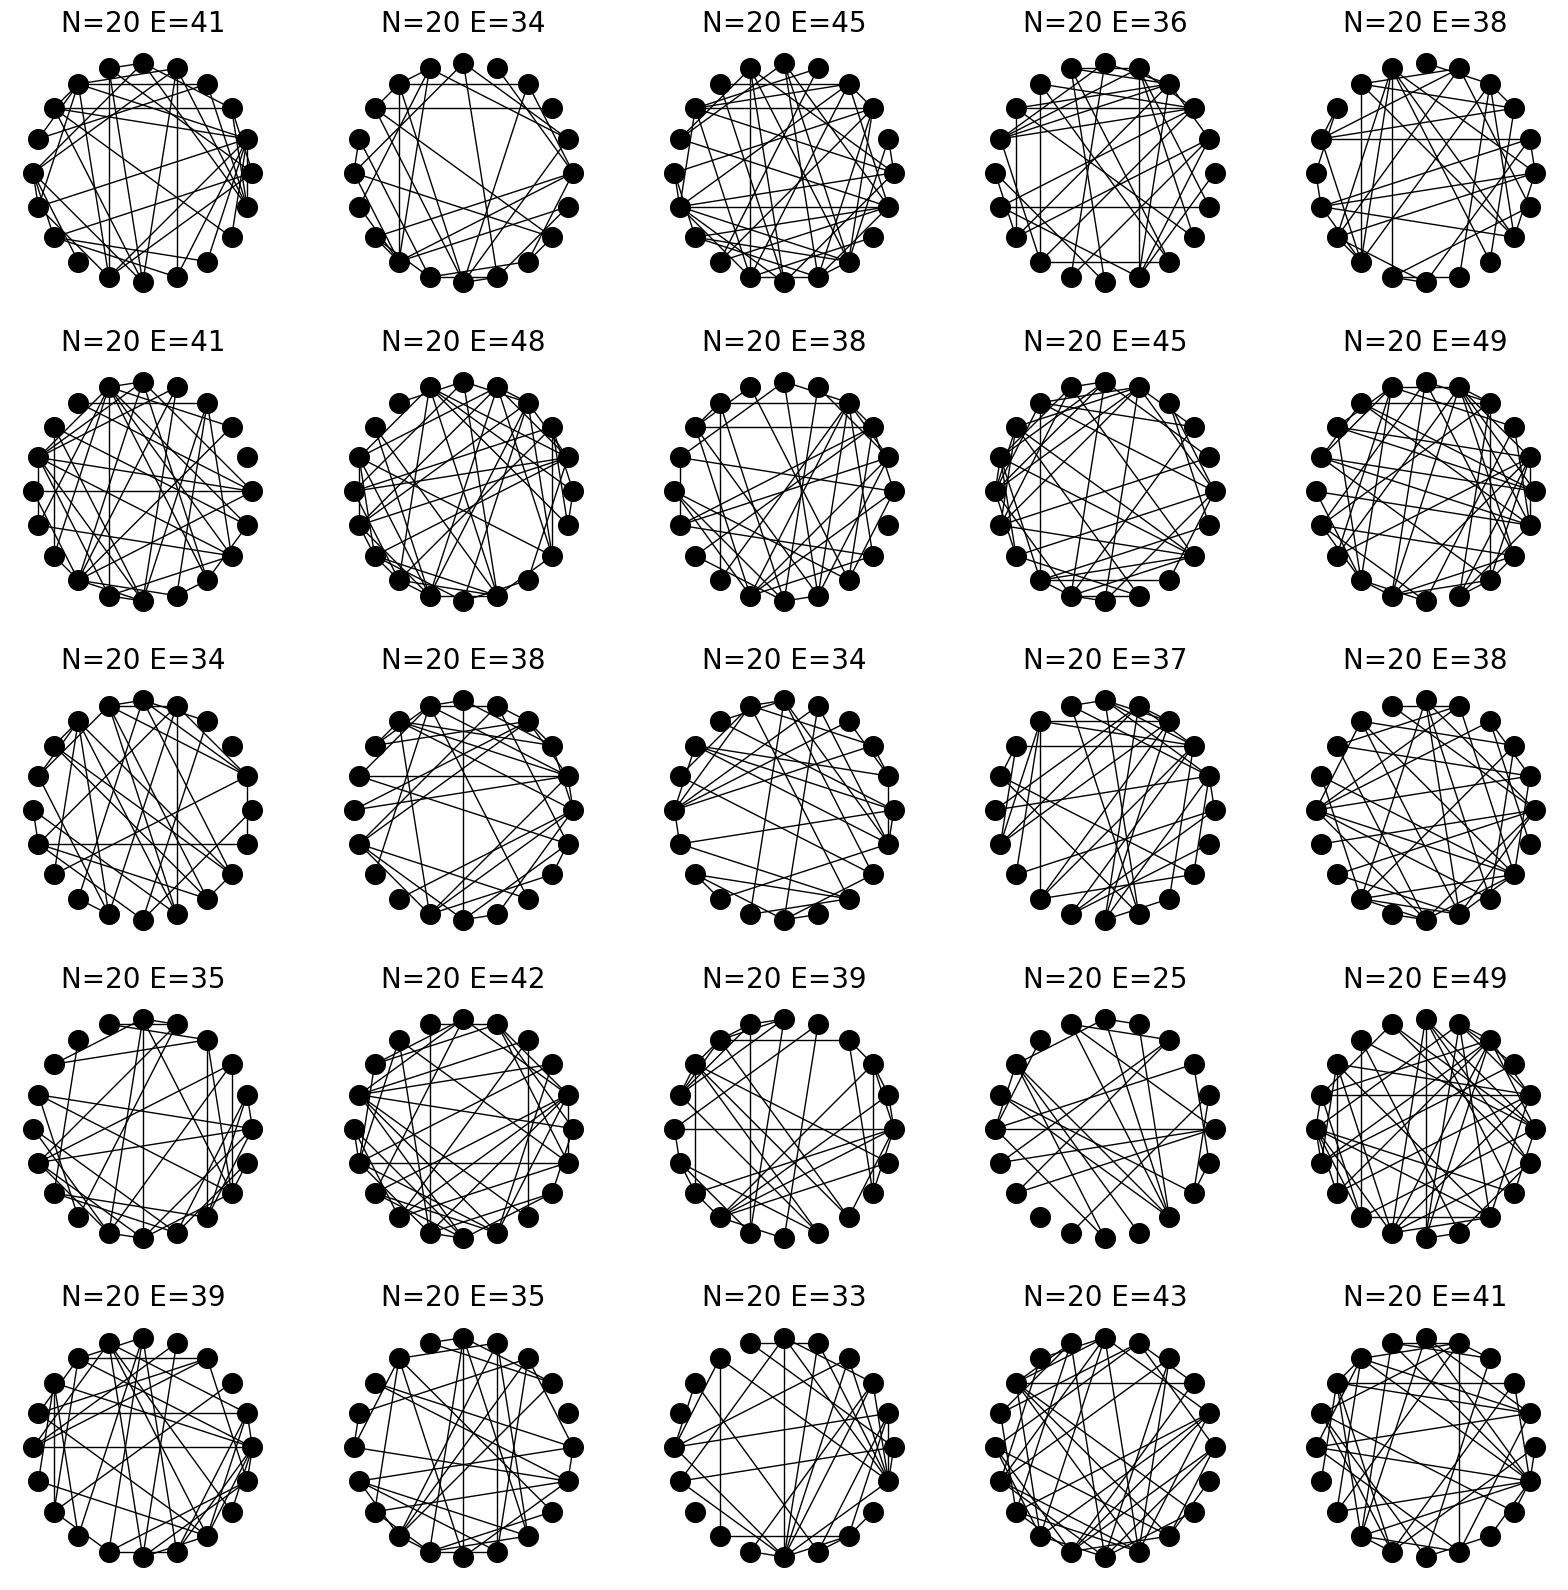

In [5]:
import numpy as np

from plot import set_figure

# plot settings
n = int(np.ceil(np.sqrt(len(graphs))))
fs = 4
fs_title = 5
background = "white"
node_size = 50*fs
edge_size = fs/4
node_color = "black"
edge_color = "black"
pos = "circular"

_, axs = set_figure(n, n, fs=fs, fc=background, fs_title=fs_title)

for i, G in enumerate(graphs):

    ax = axs[i]

    # plot graphs
    plot_graph_beautiful(G, ax, pos=pos,
                          c_node=node_color, c_edge=edge_color,
                          node_size=node_size, edge_size=edge_size)
    # set title
    ax.set_title(f"N={G.number_of_nodes()} "  # check number of nodes
                 f"E={G.number_of_edges()}")

# plt.savefig(f"./dump/random_graphs_Erdos_Renyi_pos={pos}.png", dpi=300)

## Substituting edges

We need an algorithm that substitutes $k$ edges. </br>
For a graph $G_1$ we modify it to $G_2$ (the positive) by substituting $k_p$ edges. </br>
Similarly, we create $G_3$ (the negative) by substituting $k_n$ edges. </br>

In [6]:
import random
import copy

def permute_graph_nodes(G):
    """
    Permute node ordering of a graph, returns a new graph.

    Copied from:
    https://github.com/Lin-Yijie/Graph-Matching-Networks/blob/main/GMN/dataset.py.
    """
    n = G.number_of_nodes()
    G_new = nx.Graph()
    G_new.add_nodes_from(range(n))
    perm = np.random.permutation(n)
    edges = G.edges()
    new_edges = []
    for x, y in edges:
        new_edges.append((perm[x], perm[y]))
    G_new.add_edges_from(new_edges)

    return G_new


def substitute_random_edges(G, k):
    """Substitutes k randomly picked edges in graph G by k other random (and not yet existing) edges."""

    G = copy.deepcopy(G)
    if k > G.number_of_edges():
        raise ValueError("k cannot be larger than the number of edges in the graph")

    # Pick k random edges to remove
    edges_to_remove = random.sample(list(G.edges()), k)

    # Generate k new random edges that do not already exist in the graph
    new_edges = set()
    nodes = list(G.nodes())

    while len(new_edges) < k:
        u, v = random.sample(nodes, 2)
        if (not G.has_edge(u, v)) \
            and ((u, v) not in new_edges) \
            and ((v, u) not in new_edges):
            new_edges.add((u, v))

    # Substitute the edges in the graph
    G.remove_edges_from(edges_to_remove)
    G.add_edges_from(new_edges)

    return G

Sample $G_1$ from the list of graphs. </br>
Get $G_2$ and $G_3$ by randomly substituting $k_p$ and $k_n$ edges, respectively.

In [7]:
# set number of edges to be substituted
kp, kn = 1, 2

# graphs substitution
G1 = graphs[0]  # simply extract the first graph
G2 = substitute_random_edges(G1, kp)  # get positive
G3 = substitute_random_edges(G1, kn)  # get negative

Print the difference.

In [8]:
# edge sets
edges_1 = set(G1.edges())
edges_2 = set(G2.edges())

# get removed and added edges
edges_removed = list(edges_1.difference(edges_2))  # diff between edge set 1 and edge set 2
edges_added = list(edges_2.difference(edges_1))  # diff between edge set 2 and edge set 1

# print removed and added edges: should be equal to kp (default=1)
print(f"Removed edges:\t{edges_removed}\n"
      f"Added edges:\t{edges_added}")

Removed edges:	[(0, 12)]
Added edges:	[(11, 15)]


That's nice. </br>
Now, let's **visualize** the difference.</br>
We define a plotting function specifically designed for that.

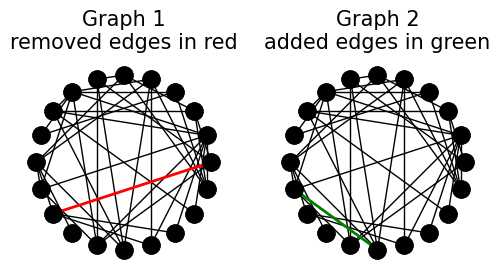

In [9]:
def plot_difference_graphs(G1, G2,
                           fs=4,
                           fs_title=5,
                           background="white",
                           node_color="black",
                           edge_color="black",
                           node_size=None,
                           edge_size=None,
                           pos = "circular"):
    """Plots difference between two graphs."""

    if node_size is None:
        node_size=50*fs,
    if edge_size is None:
        edge_size=fs/4

    if set(G1.nodes()) != set(G1.nodes()):
        raise ValueError("The node sets of the two graphs are not the same")

    # get fixed node positions if not already given
    if pos == "circular":
        pos = nx.circular_layout(G1)
    elif pos == "spring":
        pos = nx.spring_layout(G1)

    # edge sets
    edges_1 = set(G1.edges())
    edges_2 = set(G2.edges())

    # get removed and added edges
    edges_removed = edges_1.difference(edges_2)  # diff between edge set 1 and edge set 2
    edges_added = edges_2.difference(edges_1)  # diff between edge set 2 and edge set 1

    # set up plot
    _, axs = set_figure(1, 2, fs=fs, fc=background, fs_title=fs_title)

    # plot G1
    ax = axs[0]
    ax.set_title(f"Graph 1\nremoved edges in red")
    plot_graph_beautiful(G1, ax, pos=pos,
                         edge_list=list(edges_1-edges_removed),
                         c_node=node_color, c_edge=edge_color,
                         node_size=node_size, edge_size=edge_size)
    plot_graph_beautiful(G1, ax, pos=pos,
                         edge_list=list(edges_removed),
                         c_node=node_color, c_edge="red",
                         node_size=node_size, edge_size=edge_size*2)

    # plot G1
    ax = axs[1]
    ax.set_title(f"Graph 2\nadded edges in green")
    plot_graph_beautiful(G2, ax, pos=pos,
                         edge_list=list(edges_2-edges_added),
                         c_node=node_color, c_edge=edge_color,
                         node_size=node_size, edge_size=edge_size)
    plot_graph_beautiful(G2, ax, pos=pos,
                         edge_list=list(edges_added),
                         c_node=node_color, c_edge="green",
                         node_size=node_size, edge_size=edge_size*2)

# figure settings
fs = 3
node_size = fs*50
edge_size = fs/3

# plot difference
plot_difference_graphs(G1, G2, fs=fs, fs_title=5, node_size=node_size, edge_size=edge_size)

Let's do the same, but for smaller graphs ($N = 8$) and larger rate of edges ($p_e = 0.5$), and more edge substitutions ($k_p = 4$).

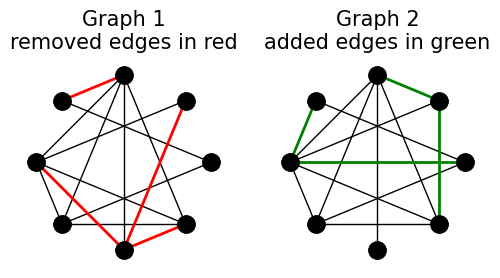

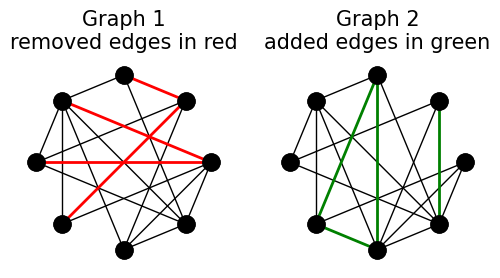

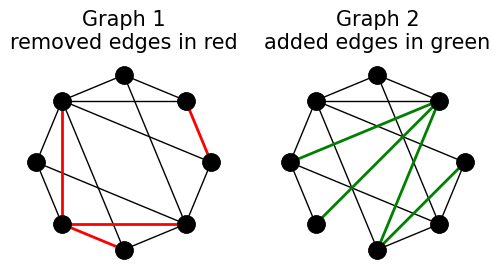

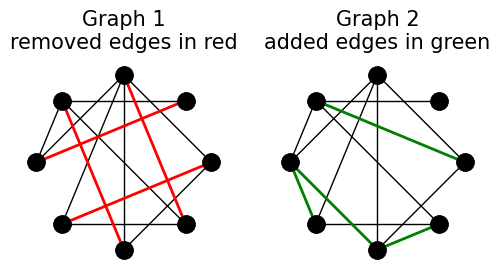

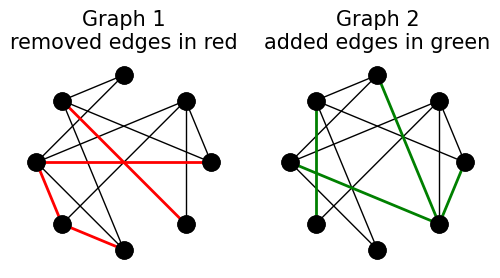

In [10]:
# get list of graphs
k = 4
graphs_small = get_random_graphs(num_graphs=5, num_nodes=8, p_edge=0.5)
graphs_perm = [substitute_random_edges(G, k) for G in graphs_small]

# figure settings
fs = 3
node_size = fs*50
edge_size = fs/3

for G1, G2 in zip(graphs_small, graphs_perm):

    # plot difference
    plot_difference_graphs(G1, G2, fs=fs, fs_title=5,
                           node_size=node_size, edge_size=edge_size,
                           pos='circular')

## Pytorch Geometric GED dataset

In the following, we develop a GED dataset within Pytorch Geometric. </br>
We use the sampling and substitution functions that we developed (upto some modifications). </br>
The node and edge features are initialized as

In [11]:
from torch_geometric.utils import from_networkx
from torch_geometric.data import Dataset
import torch

def generate_binomial_graph(num_nodes=20, pe=0.2, is_connected=True):

    n = sample_number_of_nodes(num_nodes)
    p = sample_edge_probability(pe)

    G = nx.erdos_renyi_graph(n, p)

    if is_connected:
        while not nx.is_connected(G):
            G = nx.erdos_renyi_graph(n, p)

    return G, n

def sample_number_of_nodes(num_nodes):

    if isinstance(num_nodes, list):
        n = np.random.randint(num_nodes[0], num_nodes[1])
    elif isinstance(num_nodes, int):
        n = num_nodes
    else:
        raise ValueError("Number of nodes should be a list (of two integers) or integer")

    return n

def sample_edge_probability(pe):

    if isinstance(pe, list):
        p = np.random.uniform(pe[0], pe[1])
    elif isinstance(pe, float):
        p = pe
    else:
        raise ValueError("Edge probability should be a list (of two floats) or float")

    return p

# Triplet GED dataset of graphs
class TripletDatasetGED(Dataset):
    """Graph edit distance dataset. Creates triplets.
    Samples binomial graphs and substitutes kp edges by kp other edges to form G2;
    and kn edges in the case of G3. G2: positive, G3: negative. kp < kn."""

    def __init__(self, size=10e5, num_nodes=20,
                 kp=1, kn=2, pe=0.2,
                 node_dim=None, edge_dim=None,
                 is_connected=True, permute=True):

        super(Dataset).__init__()

        self.size = int(size)
        self.num_nodes = num_nodes
        self.kp = kp
        self.kn = kn
        self.pe = pe
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.is_connected = is_connected
        self.permute = permute

        if self.kp >= self.kn:
            raise ValueError("Number of substitutions to get the positive should be "
                             "strictly lower than the negative.")

    def __len__(self):
        return self.size

    def __getitem__(self, item):

        # Sample G1 (anchor) by generating a random binomial graph
        G1, num_nodes = generate_binomial_graph(num_nodes=self.num_nodes, pe=self.pe,
                                                is_connected=self.is_connected)

        # Modify G1 to get G2 (positive) and G3 (negative) by substituting kp and kn edges, resp.
        G2 = substitute_random_edges(G1, self.kp)
        G3 = substitute_random_edges(G1, self.kn)

        # Make sure that G2 and G3 are also connected
        if self.is_connected:
            while not nx.is_connected(G2):
                G2 = substitute_random_edges(G1, self.kp)
            while not nx.is_connected(G3):
                G3 = substitute_random_edges(G1, self.kn)

        # Permute
        if self.permute:
            G1 = permute_graph_nodes(G1)
            G2 = permute_graph_nodes(G2)
            G3 = permute_graph_nodes(G3)

        # Combine all graphs. G1 is added twice to make training script easier.
        G = nx.disjoint_union_all([G1, G2, G1, G3])

        # Add 2 node attributes
        # 1) "node_feat": all ones (Note (!): can also be added later: set node_dim to None)
        # 2) "order" order index (to distinguish between G1, G2, and G3)
        if self.node_dim is not None:
            G.add_nodes_from([[n, {'node_feat': torch.ones(self.node_dim)}] for n in G.nodes()])  # add node features
        G.add_nodes_from([[n,{'order': int(np.floor(n / num_nodes))}] for n in G.nodes()])  # add order indices

        # Add edge attributes: "edge_feat": all ones
        if self.edge_dim is not None:
            G.add_edges_from([(u,v, {'edge_feat': torch.ones(self.edge_dim)}) for u, v in G.edges()])

        # Convert to PyG graph
        G = from_networkx(G)

        return G

We can now define a simple loader that takes as input the triplet dataset. </br>
Let's see what comes out.

In [12]:
from torch_geometric.loader import DataLoader

bs = 1
num_nodes = 20
dataset = TripletDatasetGED(permute=False, num_nodes=num_nodes, pe=0.5)  # permute false for plotting
dataloader = DataLoader(dataset, batch_size=bs)
data_batch = next(iter(dataloader))

print(data_batch)

print(data_batch.order)

DataBatch(edge_index=[2, 656], order=[80], num_nodes=80, batch=[80], ptr=[2])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])


Checking how long it takes to load a batch (on average). </br>
We average over 100 batches.

In [13]:
from time import time
from tqdm.auto import tqdm

# Set typical data loader
bs = 20
kp, kn = 2, 4
num_nodes = 20
dataset = TripletDatasetGED(permute=True, kp=kp, kn=kn, num_nodes=num_nodes, pe=0.2)  # permute True for training
dataloader = DataLoader(dataset, batch_size=bs)

# Initialize times list and set number of iterations
N = 100
times = []

for _ in tqdm(range(N)):
    start = time()
    batch = next(iter(dataloader))
    times.append(time()-start)

print(f"Average loading time:\n"
      f"\tPer batch(bs={bs})={np.mean(times):.3f}\n"
      f"\tPer sample(bs={bs})={np.mean(times)/bs:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Average loading time:
	Per batch(bs=20)=0.160
	Per sample(bs=20)=0.0080


For a typical training setting (bs=20, kp=2, kn=4, number of nodes=20), the time to load one batch is slightly less than 100ms (~80ms). </br>
Per sample it is approximately 4ms. </br>
For 500k training iterations, this amounts to 2000s, which is fairly below one hour.

Checking the layout options for NetworkX graphs.

In [14]:
G = nx.Graph()
G.add_nodes_from([0,1,2,5])
G.add_edges_from([(0,1), (1,3), (5,2), (2,3), (0,5)])

print(nx.circular_layout(G))

{0: array([1., 0.]), 1: array([0.30901695, 0.95105657]), 2: array([-0.80901706,  0.58778526]), 5: array([-0.809017  , -0.58778532]), 3: array([ 0.3090171 , -0.95105651])}


## Plotting a batch

For this we need another function first:

In [15]:
# Function to normalize edges
def normalize_edge(u, v):
    return tuple([min(u, v), max(u, v)])

# Function to get particular graph from a batch
def get_graph_from_batch(batch, order_id, batch_id):
    G = batch.subgraph([n for n, d in batch.nodes(data=True)
                 if (d['order'] == order_id) * (d['batch'] == batch_id)])
    return G

# Function to plot a batch of graph triplets.
def plot_graph_batch(batch, bs,
                   fs=4,
                   fs_title=5,
                   background="white",
                   node_color="black",
                   edge_color="black",
                   node_size=None,
                   edge_size=None,
                   pos_type = "circular",
                   set_title=True):
    """Plots a batch of triplet graphs."""

    if node_size is None:
        node_size=50*fs,
    if edge_size is None:
        edge_size=fs/4

    numbers = [1,2,1,3]

    # set up plot
    _, axs = set_figure(bs, 4, fs=fs, fc=background, fs_title=fs_title)

    for i, ax in enumerate(axs):

        # Set the batch and order indices
        batch_id = int(np.floor(i / 4))
        order_id = i % 4

        # Extract G1
        G1 = get_graph_from_batch(batch, 0, batch_id)

        # Extract G2 (and G3
        if order_id in (0, 2):  # G1
            G2 = get_graph_from_batch(batch, order_id+1, batch_id)
        elif order_id in (1, 3): # G2 or G3
            G2 = get_graph_from_batch(batch, order_id, batch_id)
        else:
            raise ValueError("Order should be 0, 1, 2, or 3")

        # Shift G2 (or G3) back
        # - Because graphs are packed as big graph, the nodes have a different index.
        # - Here we shift them back: simply as "node - number of nodes"
        shift = G2.number_of_nodes()
        if order_id in (2,3):
            shift *= 3
        G2_new = nx.Graph()  # initialize new G2
        G2_new.add_nodes_from([n-shift for n in G2.nodes()])  # shift nodes
        G2_new.add_edges_from([(u-shift, v-shift) for u,v in G2.edges()])  # shift edges
        G2 = copy.deepcopy(G2_new)  # overwrite G2

        # Check whether node sets are equivalent
        if set(G1.nodes()) != set(G2.nodes()):
            raise ValueError("The node sets of the two graphs are not the same")

        if order_id == 0:
            # get fixed node positions if not already given
            if pos_type == "circular":
                pos = nx.circular_layout(G1)
            elif pos_type == "spring":
                pos = nx.spring_layout(G1)
            elif pos_type == "spectral":
                pos = nx.spectral_layout(G1)
            elif pos_type == "random":
                pos = nx.random_layout(G1)
            elif pos_type == "kamada":
                pos = nx.kamada_kawai_layout(G1)
            else:
                raise ValueError("Position can only by 'circular' or 'spring'")

        # Extract edge sets
        edges_1 = set(normalize_edge(u, v) for u, v in G1.edges)
        edges_2 = set(normalize_edge(u, v) for u, v in G2.edges)

        # Compute overlap, removed, and added edge sets
        edges_removed = edges_1.difference(edges_2)  # diff between edge set 1 and edge set 2
        edges_added = edges_2.difference(edges_1)  # diff between edge set 2 and edge set 1
        edges_overlap = edges_1.intersection(edges_2)

        # Plot the graph
        graph_number = numbers[order_id]
        color = "red" if graph_number==1 else "green"
        if set_title:
            ax.set_title(f"G{graph_number}\n{color}: {'removed' if graph_number==1 else 'added'} edges")

        if graph_number == 1:
            G = G1
            edges_sub = edges_removed
        else:
            G = G2
            edges_sub = edges_added

        plot_graph_beautiful(G, ax, pos=pos,
                             edge_list=list(edges_overlap),
                             c_node=node_color, c_edge=edge_color,
                             node_size=node_size, edge_size=edge_size)

        plot_graph_beautiful(G, ax, pos=pos,
                             edge_list=list(edges_sub),
                             c_node=node_color, c_edge=color,
                             node_size=node_size, edge_size=edge_size*4)

Now we can plot the actual batch. </br>
For better visualization, we lower the number of nodes, etc

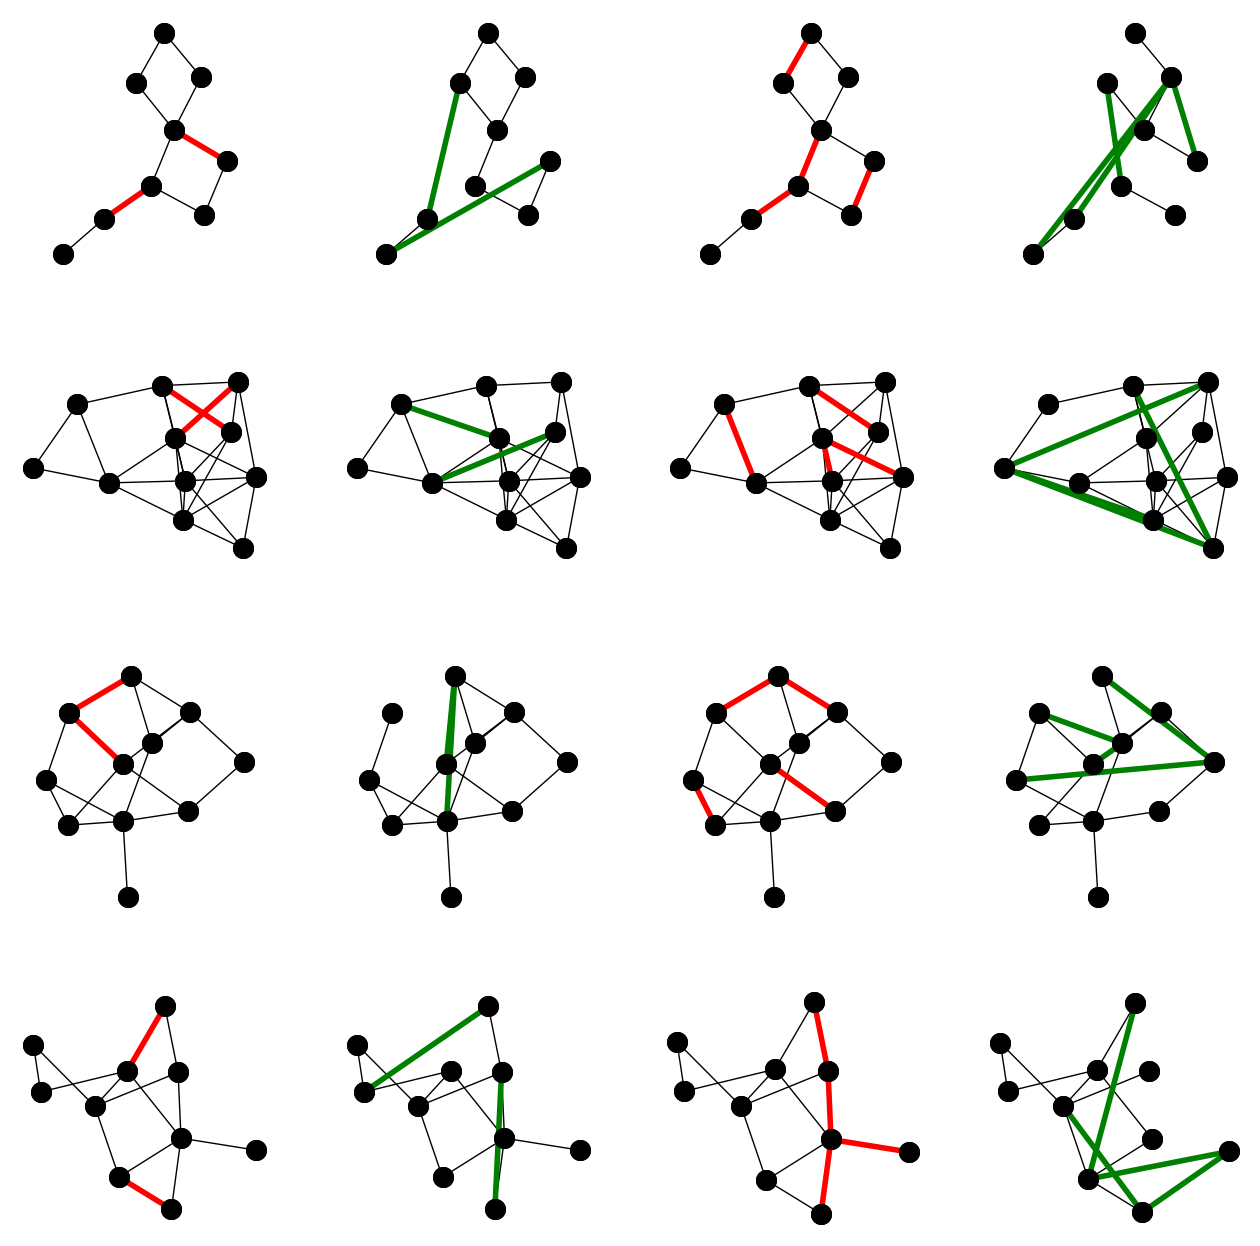

In [16]:
from torch_geometric.utils import to_networkx

# Data settings
bs = 4
num_nodes = [8, 12]
kp = 2
kn = 4
pe = 0.35

# Set dataset, loader, and batch
dataset = TripletDatasetGED(permute=False, num_nodes=num_nodes, kp=kp, kn=kn, pe=pe)  # permute false for plotting
dataloader = DataLoader(dataset, batch_size=bs)  # dataloader
batch = next(iter(dataloader))  # sample first batch
batch = to_networkx(batch, node_attrs=["order", "batch"], to_undirected=True)  # batch as NetworkX graph

# Plot the batch
fs, fs_title = 4, 4
nc = ec = "black"
bc = "white"
pos_type = "kamada"
plot_graph_batch(batch, bs, fs=fs, fs_title=fs_title, pos_type=pos_type,
                 node_color=nc, edge_color=ec, background=bc, set_title=False)

# Save batch
# plt.savefig(f"./dump/random_triplets_bs={bs}_nodes={num_nodes}_kp={kp}_kn={kn}_pe={pe}_pos={pos_type}.png", dpi=300)

## Fixed GED Datasets

This is a bit of a hack. </br>
We do not create new classes for a fixed GED dataset, but rather use the "TripletDatasetGED" class, which is defined above, to generate 1000 samples and save them for several settings. </br>
To be precise: we only use the part in which the triplets are sampled. </br>
We added a seed to make sure

The settings vary in the following:
$\bullet$ number of nodes;
$\bullet$ number of substitutions $k_p$ and $k_n$;
$\bullet$ edge probability $p_e$.

In [20]:
def get_triplet(num_nodes=20, kp=1, kn=2, pe=0.2, permute=False, is_connected=True):
    # Sample G1 (anchor) by generating a random binomial graph
    G1, num_nodes = generate_binomial_graph(num_nodes=num_nodes, pe=pe,
                                            is_connected=is_connected)

    # Modify G1 to get G2 (positive) and G3 (negative) by substituting kp and kn edges, resp.
    G2 = substitute_random_edges(G1, kp)
    G3 = substitute_random_edges(G1, kn)

    # Make sure that G2 and G3 are also connected
    if is_connected:
        while not nx.is_connected(G2):
            G2 = substitute_random_edges(G1, kp)
        while not nx.is_connected(G3):
            G3 = substitute_random_edges(G1, kn)

    # Permute
    if permute:
        G1 = permute_graph_nodes(G1)
        G2 = permute_graph_nodes(G2)
        G3 = permute_graph_nodes(G3)

    # Combine all graphs. G1 is added twice to make training script easier.
    G = nx.disjoint_union_all([G1, G2, G1, G3])

    # Add 1 node attributes: "order" order index (to distinguish between G1, G2, and G3)
    G.add_nodes_from([[n,{'order': int(np.floor(n / num_nodes))}] for n in G.nodes()])  # add order indices

    # Convert to PyG graph
    G = from_networkx(G)

    return G

Now, we can get the fixed datasets. </br>
Note to save for each setting only once!

In [21]:
from utils import save_pickle

N = 1000

for kp, kn in zip([1, 2], [2, 3]):
    for num_nodes in tqdm([8, 10, 15, 20, 30, 50], total=6):
        dataset = [get_triplet(num_nodes=num_nodes, kp=kp, kn=kn) for _ in range(N)]
        save_pickle(dataset, f"./data/FixedDatasetGED_nodes={num_nodes}_kp={kp}_kn={kn}.pickle")

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]